# KL量化

&emsp;&emsp;上一小节介绍的线性量化分为对称量化和非对称量化。非对称量化中，是将数据中的min值和max值直接映射到[-128, 127]。
同样的，对称量化是将数据的最大绝对值直接映射到127。

&emsp;&emsp;上面两种直接映射的方法比较粗暴，而 TensorRT 中的 int8 量化是基于 KL 散度来选取最佳的阈值 T 来映射到 127 中。超出阈值 T 的数据会直接映射为阈值（类似于截断映射）。

![kl量化](../../ch04/images/kl_quant.png)

&emsp;&emsp;KL散度常用来衡量两个分布P和Q之间的差异，KL散度越小，两个分布越相似，其公式定义如下:
$$
D_{KL} = \sum_{i=1}^n P(i) \log \frac{P(i)}{Q(i)}
$$

&emsp;&emsp;若 KL 散度值越小，说明这两个分布越相似，也就说明这个阈值 |T| 选择的最好。


## KL散度量化实现步骤
1. 基于原始输入数据生成拥有 2048 个 bin 的直方图
2. 在 [128, 2048] 范围内循环执行 3-5 步，寻找最佳的划分 $bin_{i}$ ;
3. [0, $bin_{i}$ ] 范围内的直方图数据作为原始 P, 并将 $bin_{i}$ 之后的直方图数据进行求和，并累加到 $bin_{i-1}$ 中，形成以 $bin_{i}$ 作为划分的最终 P 分布。
4. 对 P 分布进行量化形成 Q 分布(一般是划分和合并 bins ，计算合并后的平均值作为 Q 分布对应 bins 的值)。
5. 计算 P 分布和 Q 分布的 KL 散度。
6. 根据最小的 KL 散度来选取最佳的 $bin_{best}$ ，将 $bin_{best}$ 作为最终的阈值 threshold，即映射到 127 的阈值 T。
7. 根据最佳的阈值T来计算scale，scale = T / 127 。
8. 根据对称量化来量化原始数据（权重、激活值等等）。


maximum activation value 361.96209708403654
threshold:  1688
threshold edges: 298.33624726958067


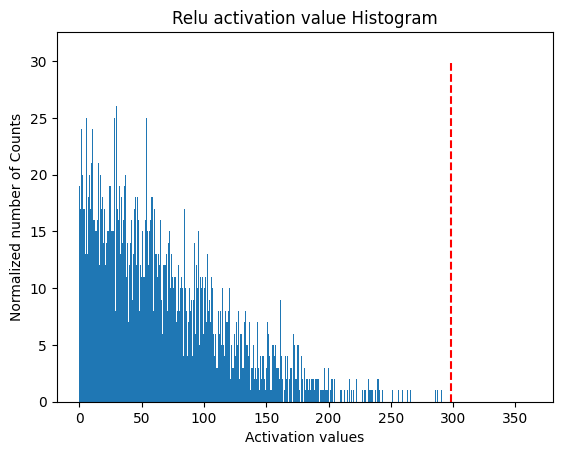

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt  
import copy
import scipy.stats as stats

# 随机生成测试数据
def generator_P(size):
    walk = []
    avg = random.uniform(0.000, 0.999)
    std = random.uniform(50.000, 99.999)
    for _ in range(size):
        walk.append(random.gauss(avg, std)) # 生成符合高斯分布的随机数
    return walk

# 平滑p和q，防止出现nan值，因为KL散度会计算log(p/q), 当q为0值时会出现nan
def smooth_distribution(p, eps=0.0001):
    is_zeros = (p == 0).astype(np.float32)
    is_nonzeros = (p != 0).astype(np.float32)
    n_zeros = is_zeros.sum()
    n_nonzeros = p.size - n_zeros
    if not n_nonzeros:
        raise ValueError('The discrete probability distribution is malformed. All entries are 0.')
    eps1 = eps * float(n_zeros) / float(n_nonzeros)
    assert eps1 < 1.0, 'n_zeros=%d, n_nonzeros=%d, eps1=%f' % (n_zeros, n_nonzeros, eps1)
    hist = p.astype(np.float32)
    hist += eps * is_zeros + (-eps1) * is_nonzeros
    assert (hist <= 0).sum() == 0
    return hist

def threshold_distribution(distribution, target_bin = 128):
    distribution = distribution[1:]
    length = distribution.size # 2047
    threshold_sum = sum(distribution[target_bin:]) # [128: ]
    kl_divergence = np.zeros(length - target_bin) # 初始化 2047 - 128 = 1919 个KL散度值
    
    for threshold in range(target_bin, length): # 遍历threshold寻找KL散度最低的阈值
        sliced_nd_hist = copy.deepcopy(distribution[:threshold]) # [0, threshold）内的作为P
        p = sliced_nd_hist.copy() # 生成p

        p[threshold - 1] += threshold_sum # 把 [threshold:] 后的累加和加到 p[threshold - 1] 中
        threshold_sum = threshold_sum - distribution[threshold] # 更新下一轮的累加和，即上一轮的累加和减去即将移入P分布的区间数据

        is_nonzeros = (p != 0).astype(np.int64) # [0:threshold]内不为0的区间
        
        quantized_bins = np.zeros(target_bin, dtype = np.int64) # 初始化量化后的bins
        num_merged_bins = sliced_nd_hist.size // target_bin # 计算多少个区间需要合并来计算平均值，例如最初有8个bins，需要合并到4个bins，则每两个bins需要进行合并

        # 合并bins
        for j in range(target_bin): 
            start = j * num_merged_bins # 合并开始的bins
            stop = start + num_merged_bins # 合并结束的bins
            quantized_bins[j] = sliced_nd_hist[start:stop].sum() # 计算区间内bins的总和
        quantized_bins[-1] += sliced_nd_hist[target_bin * num_merged_bins:].sum()

        # 计算q
        q = np.zeros(sliced_nd_hist.size, dtype = np.float64) # 初始化量化后的q
        for j in range(target_bin):
            start = j * num_merged_bins
            if j == target_bin - 1:
                stop = -1
            else:
                stop = start + num_merged_bins # 每num_merged_bins个bins进行合并组成q
            norm = is_nonzeros[start:stop].sum() # 看看合并区间里，不为0的区间个数
            if norm != 0:
                q[start:stop] = float(quantized_bins[j]) / float(norm) # 用均值（假如区间内都不为0）填充q
        
        # 平滑p和q
        p = smooth_distribution(p)
        q = smooth_distribution(q)
        # 计算p和q之间的KL散度
        kl_divergence[threshold - target_bin] = stats.entropy(p, q)

    # 寻找最小KL散度对应threshold的索引
    min_kl_divergence = np.argmin(kl_divergence)
    threshold_value = min_kl_divergence + target_bin # 计算真正的threshold, 基于最初的128, 因为一开始就是从128开始不断向外计算来扩大P的范围

    return threshold_value

if __name__ == '__main__':
    
    int_max = 127
    # 随机初始化测试数据
    size = 20000
    P = generator_P(size) 
    P = np.array(P)
    P = P[P > 0] # 保留大于0的数
    print("maximum activation value", max(np.absolute(P))) # 最大的激活值

    hist, bin_edges = np.histogram(P, bins = 2048) # 生成直方图 hist表示每一个bins对应的数量, bins表示截止 
    threshold = threshold_distribution(hist, target_bin = 128) # 返回KL散度最小的划分bins
    print("threshold: ", threshold)
    print("threshold edges:", bin_edges[threshold]) # 截止到threshold对应的bins, 能够表示的范围 bin_edges[-1]表示上面最大的激活值，即能够表示所有数

    # 计算scale
    scale = bin_edges[threshold] / int_max # 即bin_edges[threshold] / 127 
    
    # 分成 split_zie 组, density表示是否要normed
    plt.title("Relu activation value Histogram")
    plt.xlabel("Activation values")
    plt.ylabel("Normalized number of Counts")
    plt.hist(P, bins=2047)
    plt.vlines(bin_edges[threshold], 0, 30, colors = "r", linestyles = "dashed") # 红线向左就是能够表示的所有范围
    plt.show()
